# Prediction of customers' travel pattern

- Tune ML models
- Using Logistic Clf
- Discussing evaluation metrics

# 1)-Importing key modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
# For processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from collections import Counter
import datetime as dt
from datetime import datetime
import seaborn as sns
from pprint import pprint
%matplotlib inline


In [2]:
# For modeling building and tunning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.under_sampling import NearMiss

Using TensorFlow backend.


In [3]:
# for evaluation
from sklearn import metrics
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 2)-Loading & Processing data

In [5]:
df = pd.read_csv('updated_feature.csv')
df.shape

(45805, 514)

In [6]:
df.head()

,event_type,distance,num_family,len_jour,origin_ADB,origin_ADL,origin_AER,origin_AGP,origin_AKL,origin_ALA,...,dest_YEG,dest_YMQ,dest_YOW,dest_YTO,dest_YUL,dest_YVR,dest_YWG,dest_YYC,dest_YYZ,dest_ZRH
0,0,5834.154716,7,6.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6525.926149,4,21.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,469.781624,2,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1498.817537,1,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2921.339028,4,6.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_model=df.copy()

In [8]:
y=df_model["event_type"]
features=df_model.drop(['event_type'], axis=1)
X = StandardScaler().fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
nm = NearMiss()
X_under,y_under=nm.fit_sample(X_train,y_train)
# Logistic Classifeir
logreg = LogisticRegression()
logreg.fit(X_under, y_under)
predictions_LR = logreg.predict(X_test)

# 3)-Evaluation 

In [9]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
print('Over-sampled dataset shape {}'.format(Counter(y_under)))

Original dataset shape Counter({0: 30780, 1: 1283})
Over-sampled dataset shape Counter({0: 1283, 1: 1283})


In [10]:
y_test.value_counts()

0    13217
1      525
Name: event_type, dtype: int64

In [11]:
print(X_test.shape)

(13742, 513)


In [12]:
print(accuracy_score(predictions_LR,y_test))

0.20906709358172026


In [13]:
print(classification_report(predictions_LR,y_test))

              precision    recall  f1-score   support

           0       0.19      0.95      0.31      2628
           1       0.73      0.03      0.07     11114

    accuracy                           0.21     13742
   macro avg       0.46      0.49      0.19     13742
weighted avg       0.63      0.21      0.11     13742



So far, I have used classification report to show results and kept "Precicision" for main matrics of evaluation. It is time to open bag and let "cat" out of it. **Why did I choose precision as matrics of evaluation for this very case?**

### 3.1- Confusion matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
Key matrix elements are:

- true positives (TP): These are cases in which we predicted yes (booking events), and actually they do have booked events. 
- true negatives (TN): We predicted booking events from customers,actually they were search ones.
- false positives (FP): We predicted booking events from customers, but actually they were search ones. (Also known as a "Type I error.")
- false negatives (FN): We predicted search events.Those were rather booking event types. (Also known as a "Type II error.")

In [14]:
cm = confusion_matrix(predictions_LR,y_test)
cm

array([[ 2488,   140],
       [10729,   385]])

What does it mean?

- Our test sample is 13742 where we have know we have 13217 search event samples and 525 booking event samples.
- Our model has low accuracy score of 21% meaning it will pick only 3,023 correct predicts and rest are not predicted wel enough. This is not a good score. It happened because we let alot of values go in our training data and now we have more of thin data. But, there is one reason for that
- As we have assumed that our organization is not short of data. We need a model which could predict a classifier for conversion-likelihood. If we wanted a model that would predict search and booking events then we would go for over sampling option to increase data samples.
- we will not consider accuracy as our matrics of evaluation. We are not bothered if we have lower accuracy. We want to know how well our model predicts booking event instances.

Few words for confusion matrix now

- Above matrix shows that we have 385 instances where we predicted that samples are booking activities and they were actually booking event instances. They are called True positives. So, out of 525 , we picked 385 correct meaning we get 73% precision in getting right booking instances. Not bad !!!

- We have 140 cases where our model predicts search instances and they actually were booking events.This prediction error is serious for us. Luckily , we have mistake of around 26% in our model which is not a very high weightage.We shall see one way to improve this outcome later using roc-auc curve. If we more data then this could improve as well. So, this approach is working well for booking instances.

- For search instances, our model didn't do very well as we were not much concerned. We predicted search cases as correct with 2488 sample almost 19%. But, for mistakes..... we had 81% wrong prediction i.e 10729 cases. These are alot . One should expect as we had lower accuracy overall hence, our model is more precise in getting booking instances than search events.

- This is the exact why we chose "Precision" as evaluation matric compared to other. 

In [15]:
# slice confusion matrix into four pieces
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#### Matrix for Precision

In [16]:
P =(cm/cm.sum(axis=0))
P

array([[0.18824242, 0.26666667],
       [0.81175758, 0.73333333]])

### 3.2. Recall

In [17]:
print(TP / float(TP + FN))
print(recall_score(predictions_LR,y_test ))

0.03464099334173115
0.03464099334173115


- We get very low recall score. This is for booking events If we were to choose better recall focus on search events then we would have chosen recall(1-3.5=96.5% for search class).

### 3.3. Specificity
When the actual value is negative, how often is the prediction correct? <br>
How "specific" (or "selective") is the classifier?

In [18]:
# score for booking class 
print(TN / float(TN + FP))

0.9467275494672754


### 3.4. Precision
When a positive value is predicted, how often is the prediction correct?<br>
How "precise" is the classifier when predicting positive instances?

In [19]:
# for class type booking
print(TP / float(TP + FP))
print(metrics.precision_score(predictions_LR, y_test))

0.7333333333333333
0.7333333333333333


Obviously for search event type we can use 1-74= 26% shown in matrix for precision as well

# 3.GridSearchCV using Log Classifier Model

In [20]:
y=df_model["event_type"]
features=df_model.drop(['event_type'], axis=1)
X = StandardScaler().fit_transform(features)
nm = NearMiss()
X_under,y_under=nm.fit_sample(X,y)

In [21]:
lr = LogisticRegression(random_state=5, class_weight='balanced',penalty='l2')

In [22]:
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [24]:
grid_search = GridSearchCV(lr,param_grid, n_jobs=-1, scoring='precision', cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=110, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
grid_search.best_score_

0.05392323797230615

this is consistent with previous notebook K-fold.mean() for other ML model

In [26]:
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 2.0, 'dual': False, 'max_iter': 110}


In [27]:
grid_search.best_estimator_

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=110, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
grid_search.cv_results_

{'mean_fit_time': array([ 2.06494093,  2.07871528,  1.20980105,  0.63330898,  0.63135743,
        21.73921485, 22.83052139, 24.1044755 , 25.02190704, 23.97391329,
         2.11781273,  1.20654426,  0.9572154 ,  0.89981174,  0.8984704 ,
        21.70101256, 23.21017275, 25.42854195, 27.36320181, 24.69219861,
         2.05428205,  1.12290831,  0.97095017,  0.87859759,  0.86392589,
        21.61263895, 23.24171391, 25.83050027, 27.3104764 , 21.59256806,
         1.9586103 ,  1.20591726,  1.06274199,  1.01903443,  0.9253274 ,
        21.64100537, 24.39161019, 25.18763304, 25.9007268 , 21.01842799]),
 'std_fit_time': array([0.0224312 , 0.01516744, 0.72165741, 0.01295004, 0.04564048,
        0.2825195 , 0.44627378, 1.5833119 , 2.24084722, 3.12212769,
        0.48765264, 0.18651162, 0.05895899, 0.01498743, 0.01737651,
        0.32507751, 0.17753481, 0.59711192, 0.66899057, 3.64201358,
        0.2821729 , 0.13876349, 0.04216614, 0.017104  , 0.01638466,
        0.41597817, 0.15630716, 0.2782020

# 4)-predict_proba

In [29]:
grid_search.predict_proba(X_test)[0:10, :]

array([[0.47815322, 0.52184678],
       [0.73924572, 0.26075428],
       [0.42361155, 0.57638845],
       [0.63340836, 0.36659164],
       [0.6335937 , 0.3664063 ],
       [0.28259318, 0.71740682],
       [0.32793908, 0.67206092],
       [0.3866232 , 0.6133768 ],
       [0.48883902, 0.51116098],
       [0.59978904, 0.40021096]])

In [30]:
pred_prob_zero = grid_search.predict_proba(X_test)[:, 0]
print(pred_prob_zero[:5])

[0.47815322 0.73924572 0.42361155 0.63340836 0.6335937 ]


predictions_LR that we had earlier in form of either 0 or 1 was class probability. This one is probability ranging from 0-1. If it is above 0.5 (our default point) then we have book event type and below 0.5 is search event type class.

Text(0, 0.5, 'Frequency')

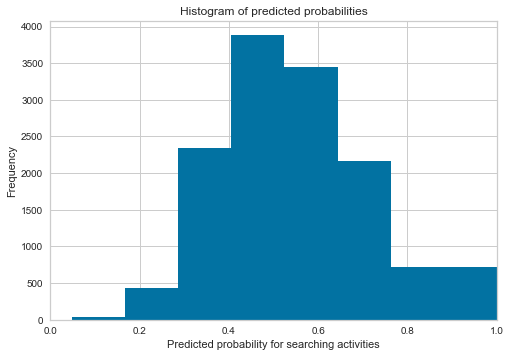

In [31]:
# histogram of predicted probabilities for search activities
plt.hist(pred_prob_zero, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability for searching activities')
plt.ylabel('Frequency')

In [32]:
pred_prob_cl_one = grid_search.predict_proba(X_test)[:, 1]
print(pred_prob_cl_one[:5])

[0.52184678 0.26075428 0.57638845 0.36659164 0.3664063 ]


Text(0, 0.5, 'Frequency')

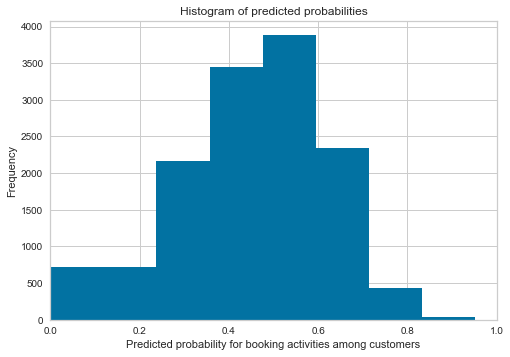

In [33]:
# histogram of predicted probabilities for churned customers
plt.hist(pred_prob_cl_one, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability for booking activities among customers')
plt.ylabel('Frequency')

These are the probabilities that for booking and search acitivities among customers.

If we still want to improve our model precision then we can change threshold. Defualt threshold for probability is 0.5. If we change then our results for booking could be more precise. There will less cases where our model would predict search results as booking. But, I will keep this current threshold Probability value.

# 5)-ROC & AUC

In [34]:
from sklearn.metrics import roc_curve
roc_score=roc_curve(y_test, pred_prob_cl_one)

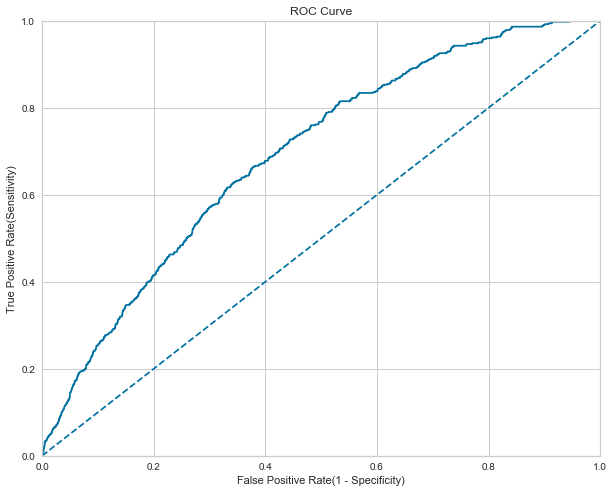

In [35]:
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, pred_prob_cl_one)


def _plot_roc_curve(fpr, tpr, thres):
    roc = plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', label = 'ROC')
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate(1 - Specificity)')
    plt.ylabel('True Positive Rate(Sensitivity)')
    plt.title('ROC Curve')
    return roc
p1 = _plot_roc_curve(fpr, tpr, thres)

This shape is what we study in book as pretty nice balance between True positive and False positives. This plot also confirm right choice of imblanced solution, model, and tuning approach.

In [36]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.692747435661864

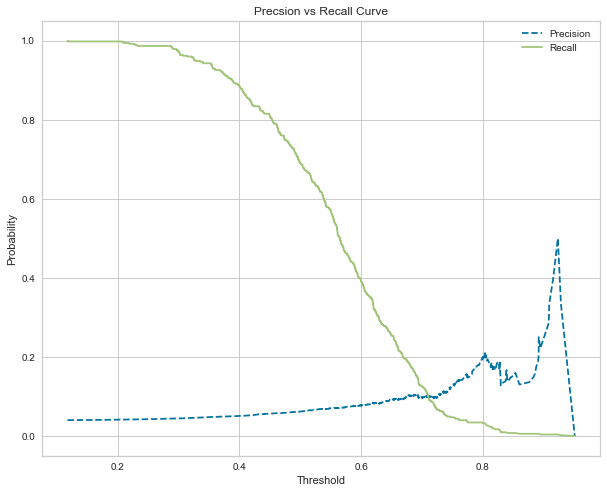

In [37]:
from sklearn.metrics import roc_curve, precision_recall_curve
prec, rec, thres = precision_recall_curve(y_test, pred_prob_cl_one)

def _plot_prec_rec_curve(prec, rec, thres):
    plot_pr = plt.figure(figsize = (10, 8))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precsion vs Recall Curve')
    plt.legend()
    #return plot_pr(it creates duplicate graph)

_plot_prec_rec_curve(prec, rec, thres)

Our intersection point is 0.7 here. If we go to lower values(i.e left of our x-axis) we can get better recall values. Higher values will improve precision but, recall will go very low. This trade off is typical in Classification problems and depending on problem how much specific outcome vs sensitive outcome is required in the end.

# Key Takeaway

- 1- It is important to undertand problem at hand. We needed a model that could predict conversion-likelihood of users. For this, we need to know which event type class is of more significance to us. Search and booking event types are two classes that we had so, it is binary classification model. And our class of interest is "booking". We got interesting insite while exploring different variables that gave us hints how our predictive model might provide us results.

- 2- Next challenge was to know how would we measure performance of our model. what will be most optimal model for us and what is a number that we are looking? Mostly accuracy is considered to be standard evaluation Metric. In our case, it was not case. Accuracy shows only percentage of correct prediction results. We wanted to see how close we predict correct "booking" event type. For this reason, I assumed precision to be right metric of evaluation. I however; provided results from other metrics as well to give a good comparison.

- 3- Out of 47007 samples, We had 45198 search instances and only 1809 book instance. Clearly, we have more search event type instances and when we train our model on random sample data then we would get better chances of predicting search instances than booking instances. This is very practical problem in ML domain.I applied machine learning first and showed by results that there is low precision for booking instances than search class instances. I proposed three solutions for this imbalnced classification problem. I chose solution with under sample given data and hence we had 1808 cased for both search and book instances. <br>
Explanation of my choice has been documented in notebook3.

- 4- Finally, feature selection. This is the only part where I didn't fully follow assignment's instruction. I chose three features that I extracted from given data i.e num_famil, len_jour, distance. These three features were of my interest. I also included ts_hour - the hour at which certain activity happened but, this variable is not significant hence, I dropped it.<br>
I didnt drop categorical variable though. I had an opportunity to explore "origin" and "destination" variables and found that they show a good relationship with event_types. I also noticed that model performance lowered removing these variables. I encoded them and then I had many many variables 500+. It looks alot. Someone might think of fewer columns. I only had 5 features but, too many columns might look too much.
First of all, they are not too much. There is a way to use fewer. One is backward elimination i.e checking p-values and see if these variables are significant or not. Eliminate all those values that are insignificant from equation and then run model again. Another approach is use TF-IDF vectorization method with keeping most frequent origin and destination entities with respect to event type class. It could be deducted to 25 most relevant airport origin and destination airports. By this, we have 53 columns. This NLP approach wasn't part of this assignment so, I didnt go too deep into that. For future work, I might explore that part.

- 5- In the end, I enjoyed working on this assignment and I really hope that you have had fun reading this code.Thank you for this great opportunity! 

**END OF NOTEBOOK5**